# Importar datos

Los datos provienen originalmente de una competición de [DrivenData](https://www.drivendata.org/competitions/66/flu-shot-learning/). Para comenzar hay que registrarse en la competición, descargar los datos y subirlos al entorno de ejecucuión de este notebook.

In [5]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import uniform
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler

In [7]:
features_df = pd.read_csv("training_set_features.csv", index_col="respondent_id")
labels_df = pd.read_csv("training_set_labels.csv", index_col="respondent_id")
#test_final= pd.read_csv("test_set_features.csv", index_col="respondent_id")

Además, tal y como establece el guion del trabajo para que los resultados del modelo reflejen realmente el aprendizaje del algoritmo que hemos diseñado es preciso apartar un conjunto de datos de test que no usaremos en ningún momento hasta la evaluación final. El propio concurso guarda una serie de datos para la evaluación de las entregas, sin embargo, preferimos realizarlo nosotros mismos. (?)

In [8]:
RANDOM_SEED = 42

X_train, X_test, y_train, y_test = train_test_split(
    features_df,
    labels_df,
    test_size=0.20,
    shuffle=True,
    stratify=labels_df,
    random_state=RANDOM_SEED
)

# Análisis Exploratorio

Exploremos los datos.

Comenzamos observando el nombre y el tipo de dato de los atributos del dataset.

In [ ]:
X_train.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
12230,2.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,"> $75,000",Not Married,Own,Not in Labor Force,bhuqouqj,Non-MSA,0.0,0.0,NaN,NaN
8871,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Own,Employed,atmpeygn,"MSA, Principle City",2.0,0.0,cfqqtusy,xgwztkwe
2390,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,"MSA, Not Principle City",0.0,0.0,NaN,NaN
9227,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Married,Rent,Not in Labor Force,atmpeygn,"MSA, Not Principle City",1.0,0.0,NaN,NaN
9064,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,lzgpxyit,"MSA, Not Principle City",0.0,0.0,wlfvacwt,xgwztkwe


In [ ]:
X_train.dtypes

,0
h1n1_concern,float64
h1n1_knowledge,float64
behavioral_antiviral_meds,float64
behavioral_avoidance,float64
behavioral_face_mask,float64
behavioral_wash_hands,float64
behavioral_large_gatherings,float64
behavioral_outside_home,float64
behavioral_touch_face,float64
doctor_recc_h1n1,float64


Por otra parte, tenemos dos 'labels' objetivo, es decir, el propósito del modelo es predecir cuales de las dos vacunas se ha puesto cada persona.

In [ ]:
print(y_train.shape)
y_train.head()

(21365, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
2921,1,0
9490,0,1
13000,0,1
4117,1,1
4857,0,0


¿Cómo se relacionan los labels? ¿son independientes? ¿están balanceadas las observaciones?

In [ ]:
pd.crosstab(
    y_test["h1n1_vaccine"],
    y_test["seasonal_vaccine"],
    margins=True,
    normalize=True
)

seasonal_vaccine,0,1,All
h1n1_vaccine,,,
0,0.497754,0.289779,0.787533
1,0.036503,0.175964,0.212467
All,0.534257,0.465743,1.000000


Comprobamos que el 46.6% de los datos corresponden a personas que recibieron la vacuna estacional mientras que solo el 21.2% recibieron la vacuna h1n1. Además, de entre las personas que tomaron la h1n1 la inmensa mayoría también recibieron la estacional. De entre las personas que recibieron la estacional se observa mayor incidencia de personas que recibieron la h1n1 comparado con las que no la recibieron.

In [9]:
joined_df = X_test.join(y_test)
print(joined_df.shape)
joined_df.head()

(5342, 37)


,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,
22317,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,Own,Employed,atmpeygn,Non-MSA,1.0,1.0,mfikgejo,kldqjyjy,0,1
1215,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,"MSA, Not Principle City",1.0,1.0,NaN,NaN,0,1
10540,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,fpwskwrf,"MSA, Principle City",1.0,3.0,xicduogh,qxajmpny,0,0
7407,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,Rent,Not in Labor Force,lzgpxyit,"MSA, Principle City",0.0,0.0,NaN,NaN,0,0
14697,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Own,Unemployed,dqpwygqj,"MSA, Not Principle City",1.0,0.0,NaN,NaN,0,0


## Relación entre las variables y los objetivos

Quizá la relación más fuerte que esperamos es la de la preocupación por el h1n1 y si la persona recibió la vacuna o no, vamos a ver cómo es dicha relación

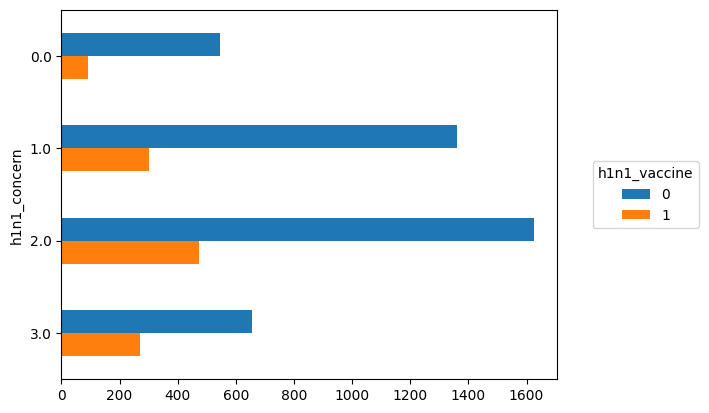

In [ ]:
counts = (joined_df[['h1n1_concern', 'h1n1_vaccine']]
              .groupby(['h1n1_concern', 'h1n1_vaccine'])
              .size()
              .unstack('h1n1_vaccine')
         )
ax = counts.plot.barh()
ax.invert_yaxis()
ax.legend(
    loc='center right',
    bbox_to_anchor=(1.3, 0.5),
    title='h1n1_vaccine'
)

In [ ]:
percentages = counts.div(counts.sum(axis=1), axis=0) * 100
percentages

h1n1_vaccine,0,1
h1n1_concern,,
0.0,85.923754,14.076246
1.0,83.992467,16.007533
2.0,76.102088,23.897912
3.0,70.489978,29.510022


Efectivamente, observamos que el porcentaje de personas que tomaron la vacuna aumenta con la preocupación por la enfermedad, si bien no el número absoluto. Sin embargo, en ningún nivel supera el porcentaje de vacunados al de no vacunados. La relación es más débil de lo que se podría pensar, indicando que hay otros factores, por ejemplo, demográficos que jugaron un papel importante en la decisión.

Investigamos las relaciones de otras variables

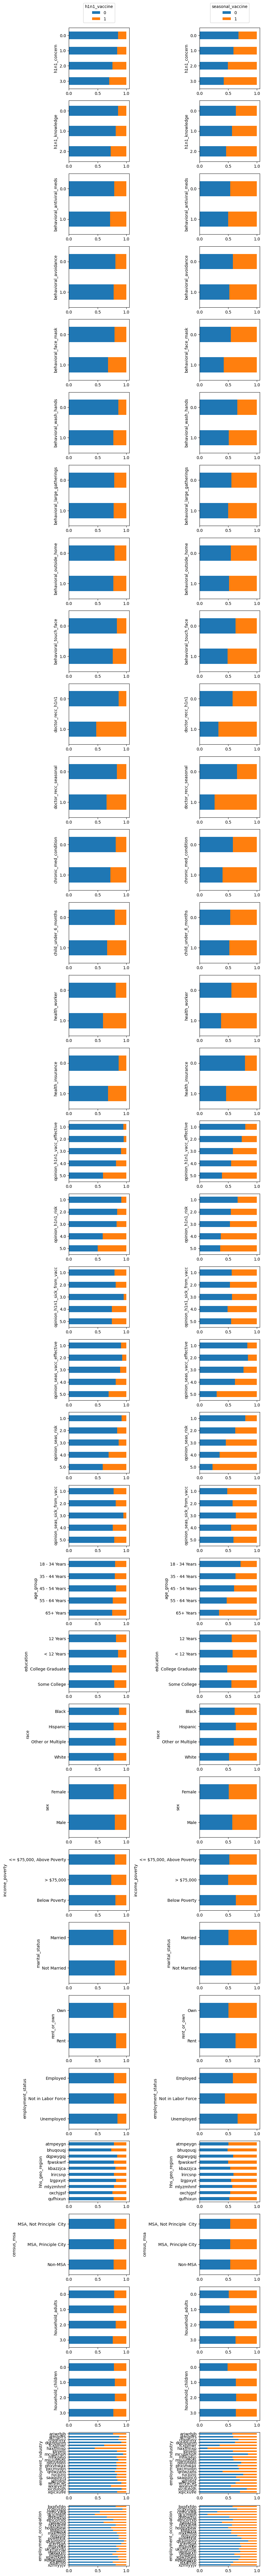

In [ ]:
def vaccination_rate_plot(col, target, data, ax=None):
    """Stacked bar chart of vaccination rate for `target` against
    `col`.

    Args:
        col (string): column name of feature variable
        target (string): column name of target variable
        data (pandas DataFrame): dataframe that contains columns
            `col` and `target`
        ax (matplotlib axes object, optional): matplotlib axes
            object to attach plot to
    """
    counts = (joined_df[[target, col]]
                  .groupby([target, col])
                  .size()
                  .unstack(target)
             )
    group_counts = counts.sum(axis='columns')
    props = counts.div(group_counts, axis='index')

    props.plot(kind="barh", stacked=True, ax=ax)
    ax.invert_yaxis()
    ax.legend().remove()

cols_to_plot = X_test.columns.tolist()

fig, ax = plt.subplots(
    len(cols_to_plot), 2, figsize=(9,len(cols_to_plot)*2.5)
)
for idx, col in enumerate(cols_to_plot):
    vaccination_rate_plot(
        col, 'h1n1_vaccine', joined_df, ax=ax[idx, 0]
    )
    vaccination_rate_plot(
        col, 'seasonal_vaccine', joined_df, ax=ax[idx, 1]
    )

ax[0, 0].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine'
)
ax[0, 1].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine'
)
fig.tight_layout()

Exploración de los valores perdidos

In [ ]:
value_counts_dict = {col: X_test[col].value_counts(dropna=False) for col in X_test.columns}

# Display results
for col, counts in value_counts_dict.items():
    print(f"Value counts for column '{col}':")
    print(counts)
    print()

Value counts for column 'h1n1_concern':
h1n1_concern
2.0    2155
1.0    1593
3.0     898
0.0     682
NaN      14
Name: count, dtype: int64

Value counts for column 'h1n1_knowledge':
h1n1_knowledge
1.0    2863
2.0    1940
0.0     518
NaN      21
Name: count, dtype: int64

Value counts for column 'behavioral_antiviral_meds':
behavioral_antiviral_meds
0.0    5086
1.0     246
NaN      10
Name: count, dtype: int64

Value counts for column 'behavioral_avoidance':
behavioral_avoidance
1.0    3881
0.0    1419
NaN      42
Name: count, dtype: int64

Value counts for column 'behavioral_face_mask':
behavioral_face_mask
0.0    4958
1.0     376
NaN       8
Name: count, dtype: int64

Value counts for column 'behavioral_wash_hands':
behavioral_wash_hands
1.0    4439
0.0     895
NaN       8
Name: count, dtype: int64

Value counts for column 'behavioral_large_gatherings':
behavioral_large_gatherings
0.0    3412
1.0    1914
NaN      16
Name: count, dtype: int64

Value counts for column 'behavioral_outsid

# Naïve Bayes

Hemos seleccionado el algoritmo Naive Bayes como algoritmo básico de entrenamiento, existen distintos tipos de Naive Bayes, según la distribución que asuma de los datos. En el caso de nuestro dataset vamos a usar Multinomial ya que es el que mejor se adapta a la tipología de los datos, no tiene sentido usar gaussian pues los datos no son continuos. Podríamos haber usado Bernoulli, esto requeriría binarizar las variables, por ejemplo con OneHotEncoding en el preprocesamiento y seleccionar los atributos más relevantes. Sin embargo, Multinomial se adapta de forma natural a nuestro dataset pues los atributos representan frecuencias.

## Preprocesamientos

### Preprocesamiento 1

In [18]:
ordinal_cols = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
               'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc']

ordinal_cols_str = ['age_group', 'education', 'income_poverty']

binary_cols = ['behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
              'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_touch_face', 'doctor_recc_h1n1',
              'doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months', 'health_worker', 'health_insurance',
              ]

binary_cols_str = ['sex', 'marital_status', 'rent_or_own']  #needs inputing of nan


nominal_cols_str = ['race', 'employment_status', 'hhs_geo_region', 'census_msa', 'employment_industry', 'employment_occupation']

numeric_cols = ['household_adults', 'household_children']

numeric_preprocessing_steps = Pipeline([
    #('standard_scaler', StandardScaler()),
    ('simple_imputer', SimpleImputer(strategy='median'))
])


ordinal_numeric_preprocessing_steps = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
    #('standard_scaler', StandardScaler())
])


ordinal_col_order = {
    'age_group': ['18 - 34 Years', '35 - 44 Years', '55 - 64 Years', '45 - 54 Years', '65+ Years'],
    'education': ['< 12 Years', '12 Years', 'Some College', 'College Graduate'],
    'income_poverty': ['Below Poverty', '<= $75,000, Above Poverty', '> $75,000']}

ordinal_str_preprocessing_steps = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal_encoder', OrdinalEncoder(categories=[ordinal_col_order[col] for col in ordinal_cols_str])), # This line should now work
    #('standard_scaler', StandardScaler())
])

binary_preprocessing_steps = Pipeline([
    ('simple_imputer', KNNImputer(n_neighbors=5)),
])

binary_str_preprocessing_steps = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal_encoder', OrdinalEncoder())
])

def mark_missing(df):
    return df.fillna("Missing")

nominal_preprocessing_steps = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal_encoder', OrdinalEncoder())
])



# Create a preprocessing pipeline for all data
data_preprocessing_pipeline1 = Pipeline([
    ("preprocessor", ColumnTransformer(
        transformers=[
            ("ordinal_numeric", ordinal_numeric_preprocessing_steps, ordinal_cols + numeric_cols),
            ("ordinal_str", ordinal_str_preprocessing_steps, ordinal_cols_str),
            ("binary", binary_preprocessing_steps, binary_cols ),
            ("binary_str", binary_str_preprocessing_steps, binary_cols_str ),
            ("nominal", nominal_preprocessing_steps, nominal_cols_str ),
        ],
        remainder="drop"
    ))
])


In [19]:
data_preprocessing_pipeline1

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ordinal_numeric',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'opinion_h1n1_vacc_effective',
                                                   'opinion_h1n1_risk',
                                                   'opinion_h1n1_sick_from_vacc',
                                                   'opinion_seas_vacc_effective',
                                                   'opinion_seas_risk',
                                                   'opinion_seas_sick_from_vac...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal_encoder',
                                                                   OrdinalEncoder())]),
                                                  ['sex', 'marital_status',
                                                   'rent_or_own']),
                                                 ('nominal',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal_encoder',
                                                                   OrdinalEncoder())]),
                                                  ['race', 'employment_status',
                                                   'hhs_geo_region',
                                                   'census_msa',
                                                   'employment_industry',
                                                   'employment_occupation'])]))])

### Preprocesamiento 2

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Función de preprocesamiento
def preprocess_data4(df):
    # 1. Eliminar columnas irrelevantes
    df.drop(columns=['health_insurance'], inplace=True)

    # 2. Asignar 'Missing' a columnas relacionadas con estado laboral
    df[['employment_industry', 'employment_occupation']] = df[['employment_industry', 'employment_occupation']].mask(
        df['employment_status'].isin(['Not in Labor Force', 'Unemployed']), 'Missing'
    )

    # 3. Imputación personalizada
    # (A) Variables ordinales: Añadir categoría 'Missing' como nueva clase será el valor máximo de categoría.
    ordinal_cols = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
                    'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk',
                    'opinion_seas_sick_from_vacc']

    # Imputar valores faltantes en columnas ordinales con el valor máximo de la categoría + 1
    for col in ordinal_cols:
        # Asegurarse de que la columna es numérica
        df[col] = pd.to_numeric(df[col], errors='coerce')
        max_value = df[col].max()  # Obtiene el valor máximo actual de la columna
        df[col] = df[col].fillna(max_value + 1) # Imputa los valores faltantes con max_value + 1

    # Orden explícito para las columnas ordinales_str
    ordinal_order = {
        # No hay valores nulos en age_group.
        'age_group': ['18 - 34 Years', '35 - 44 Years', '45 - 54 Years', '55 - 64 Years', '65+ Years'],
        # Categoría missing como educación media.
        'education': ['< 12 Years', '12 Years','Missing', 'Some College', 'College Graduate'],
        # Categoría missing por encima de pobreza y debajo de "encima de pobreza"
        'income_poverty': ['Below Poverty', 'Missing', '<= $75,000, Above Poverty', '> $75,000']
    }

    ordinal_keys = list(ordinal_order.keys())
    for col in ["education", "income_poverty"]:
        df[col] = df[col].fillna("Missing")

    ordinal_encoder = OrdinalEncoder(categories=[ordinal_order[col] for col in ordinal_keys])
    df[ordinal_keys] = ordinal_encoder.fit_transform(df[ordinal_keys])

    # (B) Variables binarias: Imputación supervisada con RandomForest
    binary_cols = ['behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
                'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_touch_face', 'doctor_recc_h1n1',
                'doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months', 'health_worker', 'sex', 'marital_status', 'rent_or_own']

    # Iterar por cada columna binaria para imputar
    for col in binary_cols:
        is_null = df[col].isnull()  # Identificar valores faltantes
        if is_null.sum() > 0:
            # Convertir todas las columnas categóricas (incluidas las binarias) a valores numéricos
            df_encoded = df.copy()

            for c in df_encoded.select_dtypes(include='object').columns:
                df_encoded[c], _ = pd.factorize(df_encoded[c])

            # Separar datos de entrenamiento y prueba
            train_data = df_encoded.loc[~is_null, :]  # Filas sin valores nulos
            test_data = df_encoded.loc[is_null, :]    # Filas con valores nulos

            # Entrenar modelo RandomForest
            clf = RandomForestClassifier(random_state=42)
            clf.fit(train_data.drop(columns=[col]), train_data[col])

            # Predecir valores faltantes
            df.loc[is_null, col] = clf.predict(test_data.drop(columns=[col]))

    # Diccionarios de mapeo para cada columna binaria de tipo object
    mappings = {
        'sex': {'Male': 0, 'Female': 1},
        'marital_status': {'Not Married': 0, 'Married': 1},
        'rent_or_own': {'Own': 0, 'Rent': 1}
    }

    # Aplicar los mapeos manuales
    for col, mapping in mappings.items():
        if col in df.columns:
            df[col] = df[col].map(mapping)

    # (C) Variables nominales: Añadir categoría 'Missing'
    nominal_cols = ['race', 'employment_status', 'hhs_geo_region', 'census_msa', 'employment_industry', 'employment_occupation']
    for col in nominal_cols:
        df[col] = df[col].fillna("Missing")

    # Codificar variables nominales con OneHotEncoder
    one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    nominal_encoded = one_hot_encoder.fit_transform(df[nominal_cols])  # Ahora genera una matriz densa

    # Crear DataFrame con las columnas codificadas
    nominal_encoded_df = pd.DataFrame(
        nominal_encoded,
        columns=one_hot_encoder.get_feature_names_out(nominal_cols),  # Nombres de las columnas generadas
        index=df.index  # Mantener el índice original del DataFrame
    )

    # (D) Variables numéricas: Imputación con KNN
    numeric_cols = ['household_adults', 'household_children']
    imputer = KNNImputer(n_neighbors=5)
    df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

    # Redondear los valores imputados al entero más cercano
    df[numeric_cols] = df[numeric_cols].round(0).astype(int)

    # Concatenar las variables nominales codificadas con el resto del DataFrame
    df.drop(columns=nominal_cols, inplace=True)
    df = pd.concat([df, nominal_encoded_df], axis=1)

    return df

## El Algoritmo de clasificación

El algoritmo básico escogido es Naive Bayes, sin embargo, existen distintos tipos de métodos Naive Bayes según la distribución a priori que se asuma de los atributos: Multinomial, Bernoulli, Gaussian.

Se trata de modelos que no dependen de forma relevante de ningún parámetros, solamente un parametro de suavización al dividir por cero, tomamos los valores predeterminado, ya que no observamos un impacto en el rendimiento de los modelos.

En cambio buscamos el mejor modelo con una búsqueda 'en rejilla' en la que comparamos Multionamial, bernoulli y Gaussian con los distintos preprocesamientos planteados por el grupo.

### Con el preprocesamiento 1

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define multiple classifiers
clf1 = MultinomialNB()  # Classifier 1
clf2 = BernoulliNB() # Classifier 2
clf3 = GaussianNB() # Classifier 3

# Wrap the classifiers with MultiOutputClassifier
multi_output_clf1 = MultiOutputClassifier(clf1)
multi_output_clf2 = MultiOutputClassifier(clf2)
multi_output_clf3 = MultiOutputClassifier(clf3)

# preprocessing_options = [
#     data_preprocessing_pipeline1,
# ]

# Define the full pipeline
full_pipeline = Pipeline([
    ("preprocessor", data_preprocessing_pipeline1),  # Placeholder for preprocessing
    ('classifier', multi_output_clf1)  # Placeholder for classifier
])

# Define parameter grid
param_grid = {
    'classifier': [multi_output_clf1, multi_output_clf2, multi_output_clf3],  # Different classifiers
}

# Perform GridSearchCV
grid_search = GridSearchCV(full_pipeline, param_grid, scoring={'accuracy': 'accuracy', 'roc_auc': 'roc_auc_ovr'}, refit='roc_auc',  cv=5, verbose=3)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)
print("Best pipeline:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END classifier=MultiOutputClassifier(estimator=MultinomialNB()), preprocessor=Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ordinal_numeric',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'opinion_h1n1_vacc_effective',
                                                   'opinion_h1n1_risk',
                                                   'opinion_h1n1_sick_from_vacc',
                                                   'opinion_seas_vacc_effective',
                                                   'opinion_seas_risk',
                             

### Con el preprocesamiento 4

In [ ]:
X_test_preprocessed = pd.read_csv("preprocessed_test_dataset.csv", index_col="respondent_id")
X_train_preprocessed = pd.read_csv("preprocessed_train_dataset.csv", index_col="respondent_id")
y_test_preprocessed = pd.read_csv("labels_test_dataset2.csv", index_col="respondent_id")
y_train_preprocessed = pd.read_csv("labels_train_dataset2.csv", index_col="respondent_id")


full_pipeline2 = Pipeline([
    ('classifier', multi_output_clf1)  # Placeholder for classifier
])

# Define parameter grid
param_grid2 = {
    'classifier': [multi_output_clf1, multi_output_clf2, multi_output_clf3],  # Different classifiers
}

# Perform GridSearchCV
grid_search2 = GridSearchCV(full_pipeline2, param_grid2, scoring={'accuracy': 'accuracy', 'roc_auc': 'roc_auc_ovr'}, refit='roc_auc',  cv=5, verbose=3)

# Fit the GridSearchCV
grid_search2.fit(X_train_preprocessed, y_train_preprocessed)
print("Best pipeline:", grid_search2.best_params_)
print("Best score:", grid_search2.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END classifier=MultiOutputClassifier(estimator=MultinomialNB()); accuracy: (test=nan) roc_auc: (test=nan) total time=   0.0s
[CV 2/5] END classifier=MultiOutputClassifier(estimator=MultinomialNB()); accuracy: (test=nan) roc_auc: (test=nan) total time=   0.0s
[CV 3/5] END classifier=MultiOutputClassifier(estimator=MultinomialNB()); accuracy: (test=nan) roc_auc: (test=nan) total time=   0.0s
[CV 4/5] END classifier=MultiOutputClassifier(estimator=MultinomialNB()); accuracy: (test=nan) roc_auc: (test=nan) total time=   0.0s
[CV 5/5] END classifier=MultiOutputClassifier(estimator=MultinomialNB()); accuracy: (test=nan) roc_auc: (test=nan) total time=   0.0s
[CV 1/5] END classifier=MultiOutputClassifier(estimator=BernoulliNB()); accuracy: (test=0.576) roc_auc: (test=0.773) total time=   0.2s
[CV 2/5] END classifier=MultiOutputClassifier(estimator=BernoulliNB()); accuracy: (test=0.578) roc_auc: (test=0.773) total time=   0.2

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last

In [ ]:
import pickle

best_model = grid_search.best_estimator_

with open('NaiveBayes.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Evaluación del mejor modelo

Obtenemos el mejor modelo de acuerdo con la métrica ROC y evaluamos sus predicciones en el conjunto de test de la partición inicial de los datos.

In [ ]:
# Predict on evaluation set using the best model
preds = best_model.predict_proba(X_test)

preds_h1n1 = preds[0][:, 1]  # Probabilities for class 1 (h1n1_vaccine)
preds_seasonal = preds[1][:, 1]  # Probabilities for class 1 (seasonal_vaccine)
preds_reshaped = np.stack([preds_h1n1, preds_seasonal], axis=1)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, preds_reshaped, average='weighted', multi_class='ovr')
print("Evaluation ROC AUC Score:", roc_auc)

Evaluation ROC AUC Score: 0.8000917608210873


Guardamos el modelo para su uso posterior

In [ ]:
import pickle

with open('NaiveBayes.pkl', 'rb') as f:
    modelNB = pickle.load(f)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OrdinalEncoder from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

def evaluate_model(best_model, X_train, y_train):
    y_pred_proba = best_model.predict_proba(X_train)
    y_pred = best_model.predict(X_train)

    # Calcular ROC AUC para cada label
    roc_auc_scores = [
        roc_auc_score(y_train.iloc[:, i], y_pred_proba[i][:, 1]) for i in range(y_train.shape[1])
    ]

    # Calcular Accuracy para cada label
    accuracy_scores = [
        accuracy_score(y_train.iloc[:, i], y_pred_proba[i].argmax(axis=1)) for i in range(y_train.shape[1])
    ]

    print("Primeras 5 probabilidades para label 0:", y_pred_proba[0][:5, 1])
    print("Primeras 5 probabilidades para label 1:", y_pred_proba[1][:5, 1], "\n")

    print(f"ROC AUC global: {roc_auc_score(y_train, y_pred)}")
    print("Accuracy global:", accuracy_score(y_train, y_pred))
    print("ROC AUC Scores de cada label:", roc_auc_scores)
    print("Accuracy Scores de cada label:", accuracy_scores, "\n")
    print("Reporte de Clasificación:")
    print(classification_report(y_train, y_pred, zero_division=0))

    return "-----------------------------------------------------------------------------------"


In [ ]:
print("TRAIN:")
print(evaluate_model(best_model, X_train, y_train))

print("TEST:")
print(evaluate_model(best_model, X_test, y_test))

TRAIN:
Primeras 5 probabilidades para label 0: [0.52439979 0.05282357 0.00090631 0.00356863 0.01792797]
Primeras 5 probabilidades para label 1: [0.96808864 0.02261101 0.39040125 0.03772735 0.33402829] 

ROC AUC global: 0.7236716971347752
Accuracy global: 0.5963491692019658
ROC AUC Scores de cada label: [0.7877601563291549, 0.7998461824900911]
Accuracy Scores de cada label: [0.7705593260004681, 0.731617130821437] 

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.47      0.62      0.53      4539
           1       0.71      0.73      0.72      9947

   micro avg       0.62      0.69      0.65     14486
   macro avg       0.59      0.67      0.63     14486
weighted avg       0.63      0.69      0.66     14486
 samples avg       0.31      0.34      0.31     14486

-----------------------------------------------------------------------------------
TEST:
Primeras 5 probabilidades para label 0: [1.62095552e-03 9.90029029e-01 3.79913914e-04

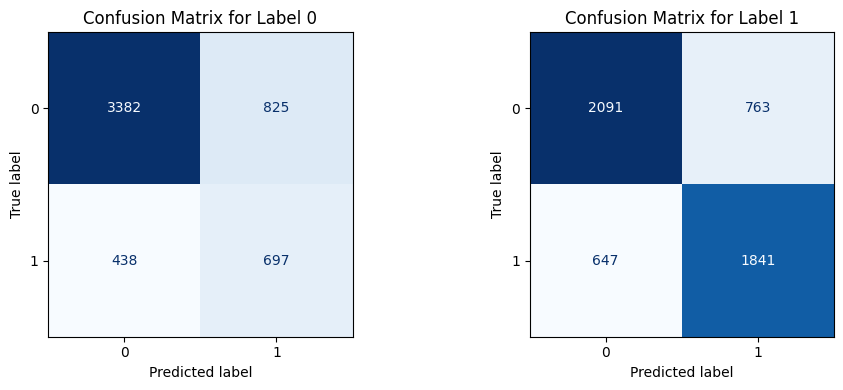

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = modelNB.predict(X_test)
fig, axes = plt.subplots(1, y_test.shape[1], figsize=(10, 4), dpi=100)
for i in range(y_test.shape[1]):
    cm = confusion_matrix(y_test.iloc[:, i], y_pred[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(f'Confusion Matrix for Label {i}')
plt.tight_layout()
plt.show()

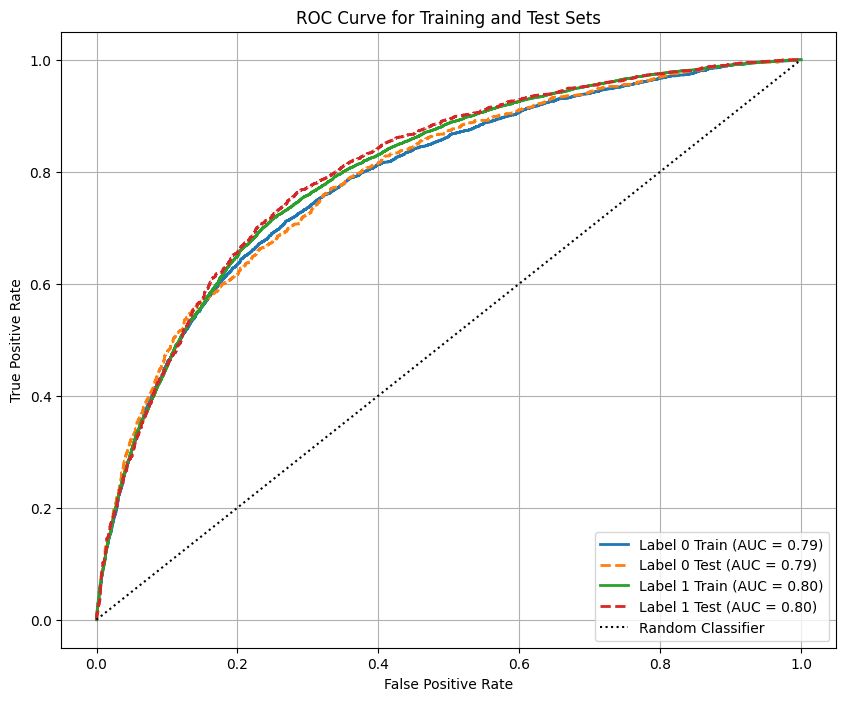

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Get probabilities for both train and test sets
y_train_proba = modelNB.predict_proba(X_train)
y_test_proba = modelNB.predict_proba(X_test)

# Plot ROC curves
plt.figure(figsize=(10, 8))

for i in range(y_test.shape[1]):  # Loop through each label
    # ROC for train and test sets
    fpr_train, tpr_train, _ = roc_curve(y_train.iloc[:, i], y_train_proba[i][:, 1])
    fpr_test, tpr_test, _ = roc_curve(y_test.iloc[:, i], y_test_proba[i][:, 1])

    # Plot both curves
    plt.plot(fpr_train, tpr_train, lw=2, label=f'Label {i} Train (AUC = {roc_auc_score(y_train.iloc[:, i], y_train_proba[i][:, 1]):.2f})')
    plt.plot(fpr_test, tpr_test, lw=2, linestyle='--', label=f'Label {i} Test (AUC = {roc_auc_score(y_test.iloc[:, i], y_test_proba[i][:, 1]):.2f})')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k:', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Training and Test Sets')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()